In [1]:
import numpy as np
import sys
import torch
import torch.nn as nn
sys.path.append('..')
import MLMD
import matplotlib.pyplot as plt


# 读取XDATCAR文件，步长为1fs

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
LiF = MLMD.atom_io.loadfile(1,"data/XDATCAR")

Reading XDATCAR...
F      : 32
Li     : 30
Loading XDATCAR...
done


# 制作测试集

In [3]:
train_data = MLMD.utilities.get_train_data(LiF)
#直角坐标
v = MLMD.utilities.diff(train_data)
#将坐标改成受力
f = MLMD.utilities.get_force_from_v(v,LiF,[19,6.941])
#球坐标
#v_s = [MLMD.neighbor_list.cartesian_to_spherical(v[i].reshape(-1,3)) for i in range(len(v))]
#临近表的建立
neighborlist = MLMD.neighbor_list.get_neighbor_atoms(train_data[0].reshape(-1,3),cutoff = 10,lattice = LiF["Li"].lattice)
#编码坐标
neighbor_coord,vec = MLMD.neighbor_list.encode_coordinantes(train_data,neighborlist,LiF["Li"].lattice,200)

# 可视化临近坐标和速度

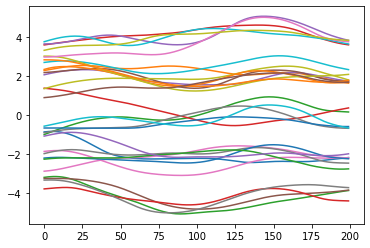

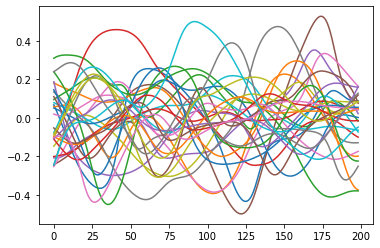

In [4]:
#print(np.array([neighbor_coord[1][i][0] for i in range(50)]))
#第一个原子前两百帧的坐标和速度：
plt.figure()
for j in range(10):
    plt.plot(np.array([neighbor_coord[1][i][j] for i in range(200)]))
plt.figure()
for j in range(10):
    plt.plot(np.array([f[i][j] for i in range(199)]))
    #plt.plot(np.array([v_s[i][j][2] for i in range(500)]))

# 制作原子类型表（对网络重要）

In [5]:
#0是F 1是Li
neighbor_atom_kind = MLMD.neighbor_list.get_atom_kind_list(neighborlist,LiF)

# 至此我们获得了一个名叫neighbor_coord的list，每一项为对应原子序数的临近原子100帧内的运动轨迹，如第0个原子视角下，第一个原子10帧内的运动:

In [16]:
print(np.array([neighbor_coord[1][i][0] for i in range(10)]))

[[-0.85783182  2.27959982 -0.99105671]
 [-0.84904634  2.29356477 -0.96200331]
 [-0.84192977  2.30759732 -0.93289562]
 [-0.83657855  2.32168236 -0.90379564]
 [-0.83308801  2.33578835 -0.87477275]
 [-0.83154982  2.34987177 -0.84588886]
 [-0.83206141  2.3638824  -0.81718538]
 [-0.83473405  2.37778268 -0.78871292]
 [-0.83964655  2.39151878 -0.76050184]
 [-0.84686537  2.40501728 -0.73258031]]


# 开始训练第一个原子（激动）

Epoch [50/150], Loss: 3.379e-03
Epoch [100/150], Loss: 4.655e-06
Epoch [150/150], Loss: 1.743e-06


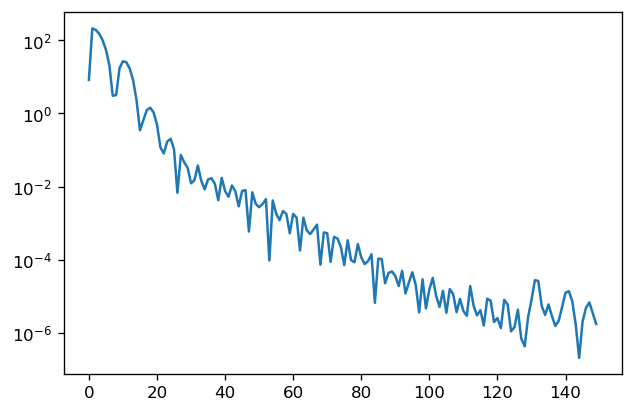

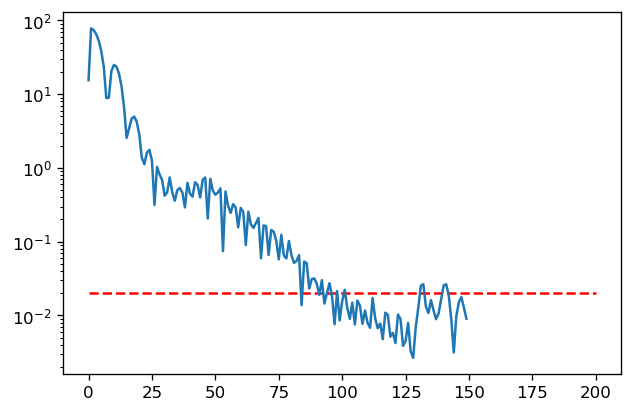

In [6]:
#模型的构建
embed_layers = [16,64]#
linear_layers = [128,256]#64,32
atom = 0
atom_list = neighbor_atom_kind[0]
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLMD.model.DNN_sym_new(2,atom, atom_list, embed_layers, linear_layers).to(device)
#print(model)

num_epochs = 150
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.004)#0.005挺好 weight_decay=1e-7
scheduler = MLMD.model.SchedulerCosineDecayWarmup(optimizer, 0.001, 1, 300)

loss_array = []   #draw picture
error_array = []
loss = 1

# 训练第一个原子的临近行为
while loss >= 1:
    
    optimizer = torch.optim.AdamW(model.parameters(), lr = 0.006)
    scheduler = MLMD.model.SchedulerCosineDecayWarmup(optimizer, 0.006, 30, 200)
    
    for epoch in range(num_epochs):
        # Get the input and target arrays
        
        input_array = torch.from_numpy(neighbor_coord[0][epoch]).float().to(device)
        target_array = torch.from_numpy(f[epoch][0]).float().to(device)   #train_data+1 v不加
        output_array = model(input_array)

        #loss = torch.norm(target_array-output_array)/torch.norm(target_array)
        
        loss = criterion(output_array, target_array)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        ta = target_array.cpu().numpy()
        oa = output_array.cpu().detach().numpy()
        error_array.append(np.linalg.norm(ta-oa)/np.linalg.norm(ta))
        if (epoch+1) % 50 == 0:
            print('Epoch [{}/{}], Loss: {:.3e}'.format(epoch+1, num_epochs, loss.item()))
        loss_array.append(loss.item())

import matplotlib.pyplot as plt
plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")
plt.figure(dpi=120)
plt.plot(error_array)
plt.yscale("log")
plt.hlines(0.02,0,200,"r","--")

# 输出百分比误差

In [7]:
ta = target_array.cpu().numpy()
oa = output_array.cpu().detach().numpy()

print(ta,oa,loss)
print(np.linalg.norm(ta-oa)/np.linalg.norm(ta))
#print(target_array - output_array)

[-0.11171021  0.22678663  0.02266802] [-0.11000711  0.22653866  0.02417355] tensor(1.7429e-06, grad_fn=<MseLossBackward0>)
0.009008798


# 效果不错 接下来训练所有的原子

第 1个原子，Loss: 3.68848e-05,cpu time: 9.99s
第 2个原子，Loss: 3.75325e-05,cpu time: 1.99s
第 3个原子，Loss: 3.99665e-05,cpu time: 19.87s
第 4个原子，Loss: 1.80439e-06,cpu time: 0.99s
第 5个原子，Loss: 8.34162e-06,cpu time: 1.99s
第 6个原子，Loss: 7.68329e-07,cpu time: 0.99s
第 7个原子，Loss: 7.39679e-06,cpu time: 1.00s
第 8个原子，Loss: 8.73901e-07,cpu time: 1.00s
第 9个原子，Loss: 6.95563e-07,cpu time: 0.99s
第10个原子，Loss: 1.38357e-05,cpu time: 0.99s
第11个原子，Loss: 4.14747e-06,cpu time: 1.00s
第12个原子，Loss: 4.92349e-06,cpu time: 2.99s
第13个原子，Loss: 1.04180e-05,cpu time: 1.00s
第14个原子，Loss: 1.15917e-05,cpu time: 1.00s
第15个原子，Loss: 8.41643e-06,cpu time: 1.00s
第16个原子，Loss: 3.00887e-06,cpu time: 1.00s
第17个原子，Loss: 1.31569e-06,cpu time: 1.00s
第18个原子，Loss: 4.11956e-06,cpu time: 2.98s
第19个原子，Loss: 1.67216e-06,cpu time: 1.00s
第20个原子，Loss: 5.08756e-07,cpu time: 1.00s
第21个原子，Loss: 9.99384e-07,cpu time: 0.99s
第22个原子，Loss: 1.74943e-07,cpu time: 0.99s
第23个原子，Loss: 5.77723e-06,cpu time: 1.00s
第24个原子，Loss: 2.04798e-05,cpu time: 1.00s
第25个原子，Loss: 4.

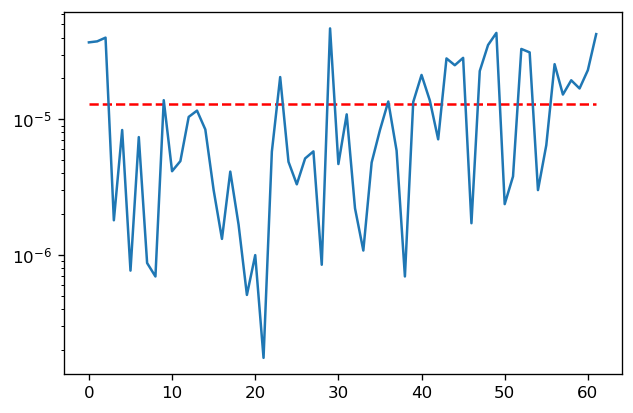

In [6]:
model_list = []
loss_array = [] #每个原子训练200轮的loss
embed_layers = [16,64]#
linear_layers = [128,256]#64,32

import time

for atom_num in range (62):
    time1 = time.time()
    atom = 0 if atom_num <=31 else 1
    atom_list = neighbor_atom_kind[atom_num]
    model_list.append(MLMD.model.DNN_sym_new(2,atom, atom_list, embed_layers, linear_layers).to("cpu"))
    model = model_list[-1]
    #print(model_list[-1])
    criterion = nn.MSELoss()
    #optimizer = torch.optim.AdamW(model.parameters(), lr = 0.004,)#weight_decay=1e-7
    #scheduler = MLMD.model.SchedulerCosineDecayWarmup(optimizer, 0.004, 1, 300)
    num_epochs = 120  
    loss = 1
    
    while loss >= 5e-5:
        
        optimizer = torch.optim.AdamW(model.parameters(), lr = 0.004)
        scheduler = MLMD.model.SchedulerCosineDecayWarmup(optimizer, 0.004, 1, 300)
        for epoch in range(num_epochs):

        # 训练第一个原子的临近行为

            input_array = torch.from_numpy(neighbor_coord[atom_num][epoch]).float().to("cpu")
            target_array = torch.from_numpy(v[epoch].reshape(-1,3)[atom_num]).float().to("cpu")   #train_data+1 v不加
            output_array = model(input_array)

            loss = criterion(output_array, target_array)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            scheduler.step()
            
            #Print the loss every 10 epochs
            #if (epoch+1) % 150 == 0:
                #print('Epoch [{}/{}], Loss: {:.9f}'.format(epoch+1, num_epochs, loss.item()))
                
    loss_array.append(loss.item())
    time2 = time.time()
    print("第{:2d}个原子，Loss: {:.5e},cpu time: {:.2f}s".format(atom_num+1,loss.item(),time2-time1))
    
plt.figure(dpi=120)
plt.plot(loss_array)
plt.hlines(np.mean(loss_array),0,61,"r","--")
plt.yscale("log")


# 更新下一个帧原子的速度并输出当前步的百分比误差

In [7]:
start_frame = num_epochs
v_predicted = MLMD.utilities.predict_v([neighbor_coord[i][start_frame] for i in range(62)],model_list,62)
print((np.linalg.norm(v_predicted - v[start_frame].reshape(-1,3)))/np.linalg.norm(v[start_frame].reshape(-1,3)))


0.06496433583594509


# 往后更新10帧，每一帧和真实的数据比较RMSD

In [8]:
predict_coord = [train_data[start_frame].reshape(-1,3)]

def ML_step(predict_coord,predict_num,vec,atomic_mass_rev):

    predict_neighbor_list = MLMD.neighbor_list.get_neighbor_atoms(predict_coord[-1],cutoff = 10,lattice = LiF["Li"].lattice)
    predict_vlist = []
    #print(predict_coord)
    for i in range(predict_num):      
        predict_neighbor_coord = []
        predict_neighboratom = MLMD.neighbor_list.get_coordinates_from_indices(predict_coord[-1],predict_neighbor_list)
        for j ,k in enumerate(predict_neighboratom):
            #平移到中心           
            vector_3d = np.tile(predict_coord[-1][j],(k.shape[0],1))
            predict_neighbor_coord.append(k-vector_3d + vec[j] ) 
        f_predicted = MLMD.utilities.predict_v([predict_neighbor_coord[l] for l in range(62)],model_list,62) 

        #受力改成坐标
        v_predicted = MLMD.utilities.get_force_from_v(f_predicted,LiF,atomic_mass_rev)
        
        predict_vlist.append(v_predicted)
        predict_coord.append(MLMD.utilities.step(predict_coord[-1],v_predicted))

    return predict_coord,predict_vlist
    
predict_coord,predict_vlist = ML_step(predict_coord,10,vec,[1/19,1/6.941])


In [9]:
MLMD.utilities.gen_xdatcar(predict_coord,LiF)

# 可以看出10步后，百分比误差大概在1%左右

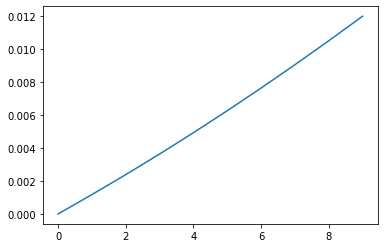

In [9]:
bias = []
for i in range(10):
    bias.append(np.linalg.norm(predict_coord[i] - train_data[start_frame+i].reshape(-1,3))/np.linalg.norm(train_data[start_frame+i].reshape(-1,3)))

plt.plot(bias)

In [134]:
import ase
from ase.io import read ,write
from ase.build import sort
from ase.visualize import view

# 将某一帧写出成CONTCAR

In [11]:
output = predict_coord[9]
outv = predict_vlist[9]
MLMD.utilities.gen_contcar(output,outv,LiF,"POSCAR")

In [83]:
import os

# 和VASP进行一个对接

In [12]:

os.system('cd vasprun;qsub vasp5.pbs')

#os.system("pwd /")


5532.node01


0

In [85]:
#for j in range(11):
    #plt.plot(np.array([predict_vlist[i][j] for i in range(30)]))

In [86]:
#测试ML和QM的误差

LiF_new = MLMD.atom_io.loadfile(1,"vasprun/XDATCAR")
test_data = np.array([np.array(np.append(LiF_new["F"].position[i],LiF_new["Li"].position[i])) for i in range(len(LiF_new["F"].position))])
testv = MLMD.utilities.diff(test_data)

#print(predict_vlist[5])          

Reading XDATCAR...
F      : 32
Li     : 30
Loading XDATCAR...
done


第9帧和vasp数据对比

In [61]:
#print(testv[0].reshape(-1,3))
#testv_predicted = MLMD.utilities.predict_v([test_neighbor_coord[i] for i in range(62)],model_list,62)
#受力改成坐标
#testv_predicted[:96] /= 19
#testv_predicted[96:] /= 6.941

#print((np.linalg.norm(predict_vlist[5] - testv[0].reshape(-1,3))))

In [21]:
#Learn from QM

for i in range(1):

    test_neighbor_coord = []
    
    neighboratom = MLMD.neighbor_list.get_coordinates_from_indices(test_data[i].reshape(-1,3),neighborlist)

    
    for j ,k in enumerate(neighboratom):  
        vector_3d = np.tile(test_data[i].reshape(-1,3)[j],(k.shape[0],1))   
        test_neighbor_coord.append(k - vector_3d + vec[j])

    for atom_num in range(62):
        
        model = model_list[atom_num]

        optimizer = torch.optim.AdamW(model.parameters(), lr = 0.04)
        input_array = torch.from_numpy(test_neighbor_coord[atom_num]).float().to("cpu")           
        target_array = torch.from_numpy(testv[i].reshape(-1,3)[atom_num]).float().to("cpu")   #train_data+1 v不加        
        output_array = model(input_array)
        loss = criterion(output_array, target_array)
        
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
        #print(loss)

    


NameError: name 'test_data' is not defined

In [ ]:
#Learn from QM
def QM_step():
    #更新coord，v
    pass

def learn_from_QM():
    #更新model
    pass


# 将结果导出成XDATCAR

In [22]:
#def pbc_res(frame):
#    #在更新位置时考虑周期性边界条件
#    frame[frame < 0] += 1
#    frame[frame > 1] -= 1
#    return np.array(frame)

def gen_xdatcar(coord,atom_dict):
    with open('XDATCAR', 'w') as f:
        lattice_inv = np.mat(list(atom_dict.values())[0].lattice).I
        f.write("vasp\n")
        f.write("1.0\n")
        for i in (list(atom_dict.values())[0].lattice):
            f.write(str(i)[1:-1]+"\n")
        for (i,j) in atom_dict.items():
            f.write(j.name + " ")
        f.write("\n")
        for (i,j) in atom_dict.items():
            f.write(str(j.number) + " ") 
        f.write("\n")
        for i in range(len(coord)):
            f.write("Direct configuration=       "+str(i+1)+"\n")
            for j in np.array(coord[i]):
                f.write(str(j.dot(lattice_inv))[2:-2]+"\n")    

In [23]:
gen_xdatcar(predict_coord,LiF)
